In [1]:
# -*- coding: utf-8 -*-
"""
01_data_analysis_and_preparation.ipynb

Ce notebook est dédié au chargement, nettoyage et à l'analyse exploratoire
des données MovieLens. Il prépare également les jeux de données d'entraînement
et de test pour les modèles de recommandation.
"""

# Importations nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull, regexp_extract, lit, min, max, year, desc, regexp_replace,sum as spark_sum,avg
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- Section 1: Analyse sur toutes les données ---

print("--- Démarrage de la SparkSession pour l'analyse globale ---")
spark = SparkSession.builder \
    .appName("FullDataAnalysis") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()



--- Démarrage de la SparkSession pour l'analyse globale ---


In [2]:
# Importations nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull, regexp_extract, lit, min, max, year, desc, regexp_replace,sum as spark_sum,avg, explode, split
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:
# Configuration pour afficher plus de colonnes
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxResults", 10) # Affiche 10 lignes par défaut pour show()

print("Chargement des datasets...")
# Assurez-vous que les fichiers CSV sont dans le bon chemin
# Si vous utilisez Jupyter, ils devraient être à côté de votre notebook ou dans un sous-dossier
try:
    df_ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
    df_movies = spark.read.csv("movies.csv", header=True, inferSchema=True)
    df_links = spark.read.csv("links.csv", header=True, inferSchema=True)
    df_tags = spark.read.csv("tags.csv", header=True, inferSchema=True)
    print("Datasets chargés avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement des fichiers : {e}")
    print("Vérifiez que les fichiers CSV (ratings.csv, movies.csv, links.csv, tags.csv) sont dans le bon répertoire.")
    # Arrêtez Spark si le chargement échoue pour éviter des erreurs ultérieures
    spark.stop()
    exit() # Quitte le script si le chargement est essentiel



Chargement des datasets...
Datasets chargés avec succès.


In [4]:
# --- Nettoyage des données - Datasets Complets ---
print("\n--- Nettoyage des données (Globale) ---")

# Renommer les colonnes pour uniformité si nécessaire (ici, pas nécessaire pour userId, movieId, rating)
# df_ratings = df_ratings.withColumnRenamed("userId", "user_id").withColumnRenamed("movieId", "movie_id")

# Vérification des valeurs manquantes
print("\nValeurs manquantes dans df_ratings:")
df_ratings.select([count(when(isnull(c), c)).alias(c) for c in df_ratings.columns]).show()

print("\nValeurs manquantes dans df_movies:")
df_movies.select([count(when(isnull(c), c)).alias(c) for c in df_movies.columns]).show()

# Suppression des lignes avec des valeurs manquantes si nécessaire (souvent pour ratings)
# Pour MovieLens, les datasets sont généralement très propres, mais c'est une bonne pratique
initial_ratings_count = df_ratings.count()
df_ratings = df_ratings.na.drop()
if df_ratings.count() < initial_ratings_count:
    print(f"Supprimé {initial_ratings_count - df_ratings.count()} lignes avec des valeurs manquantes dans df_ratings.")

# Gestion des doublons dans df_ratings
print("\nVérification et suppression des doublons dans df_ratings (userId, movieId, timestamp):")
initial_count_dedup = df_ratings.count()
df_ratings = df_ratings.dropDuplicates(['userId', 'movieId', 'timestamp'])
if df_ratings.count() < initial_count_dedup:
    print(f"Supprimé {initial_count_dedup - df_ratings.count()} doublons dans df_ratings.")
else:
    print("Aucun doublon trouvé dans df_ratings.")

# Extraire l'année du titre du film et la convertir en entier
# Utilise une regex pour trouver l'année entre parenthèses à la fin du titre
df_movies = df_movies.withColumn("release_year", regexp_extract(col("title"), "\\((\\d{4})\\)$", 1).cast(IntegerType()))
# Gérer les films sans année dans le titre (peut être null après extraction)
df_movies = df_movies.na.fill({"release_year": 1900}) # Remplir avec une année par défaut si absente

# Nettoyer le titre du film pour retirer l'année entre parenthèses
df_movies = df_movies.withColumn("title", regexp_replace(col("title"), "\\s\\(\\d{4}\\)$", ""))


--- Nettoyage des données (Globale) ---

Valeurs manquantes dans df_ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+


Valeurs manquantes dans df_movies:
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+


Vérification et suppression des doublons dans df_ratings (userId, movieId, timestamp):
Aucun doublon trouvé dans df_ratings.


In [5]:
# --- Analyse Exploratoire des Données (EDA) - Datasets Complets ---
print("\n--- Analyse Exploratoire des Données (Globale) ---")

print("\nSchéma et 5 premières lignes de df_ratings:")
df_ratings.printSchema()
df_ratings.show(5)

print("\nSchéma et 5 premières lignes de df_movies (après nettoyage):")
df_movies.printSchema()
df_movies.show(5)

print(f"\nNombre total de notes : {df_ratings.count()}")
print(f"Nombre total de films : {df_movies.count()}")
print(f"Nombre total d'utilisateurs : {df_ratings.select('userId').distinct().count()}")

# Films les mieux notés en moyenne (avec un minimum de notes pour la fiabilité)
print("\nTop 10 films les mieux notés (globale, min 1000 notes):")
# Joindre les notes et les films
df_full_ratings_movies = df_ratings.join(df_movies, on="movieId", how="inner")
# Calculer la moyenne des notes et le nombre de notes par film
avg_ratings_overall = df_full_ratings_movies.groupBy("title", "genres") \
    .agg(
        count("rating").alias("num_ratings"),
        (spark_sum("rating") / count("rating")).alias("avg_rating")
    ) \
    .filter(col("num_ratings") >= 1000) \
    .orderBy(col("avg_rating").desc(), col("num_ratings").desc()) \
    .limit(10)
avg_ratings_overall.show(truncate=False)


--- Analyse Exploratoire des Données (Globale) ---

Schéma et 5 premières lignes de df_ratings:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1217|   5.0| 943231236|
|     2|     31|   5.0| 836423902|
|     7|    231|   3.0| 840385502|
|     7|    541|   5.0| 840386223|
|     8|    858|   4.0|1553765387|
+------+-------+------+----------+
only showing top 5 rows


Schéma et 5 premières lignes de df_movies (après nettoyage):
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- release_year: integer (nullable = false)

+-------+--------------------+--------------------+------------+
|movieId|               title|              genres|release_year|
+-------+--------------------+---------

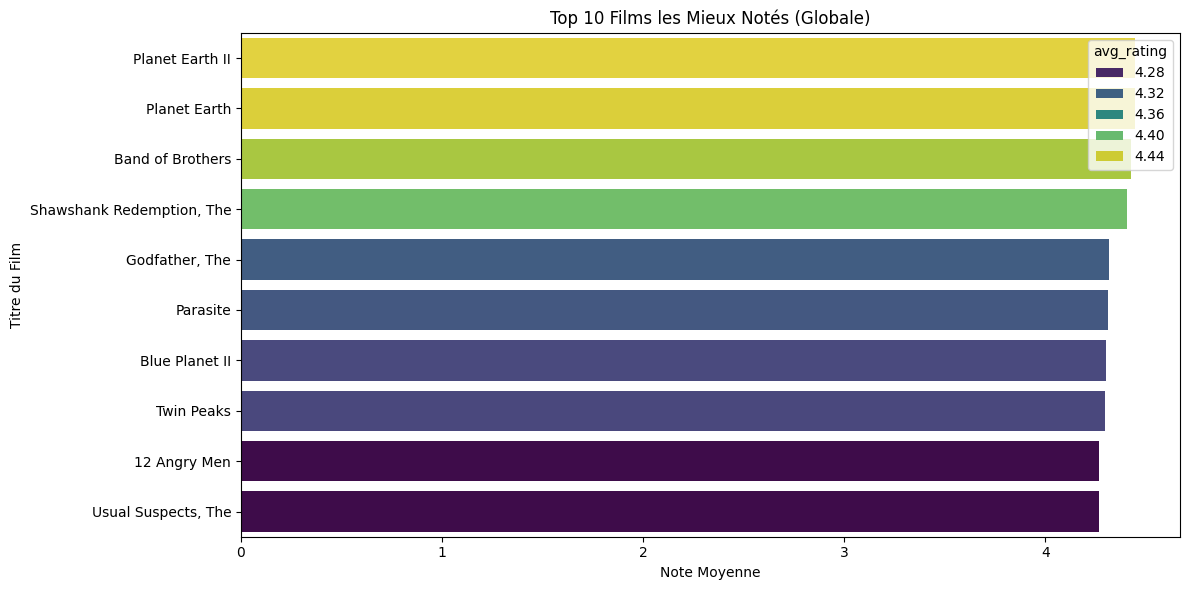

In [6]:
# Tri du DataFrame avant le plot
df_top10_sorted = avg_ratings_overall.toPandas().sort_values("avg_rating", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="avg_rating",
    y="title",
    hue="avg_rating",
    data=df_top10_sorted,
    palette="viridis",
    dodge=False
)
plt.title("Top 10 Films les Mieux Notés (Globale)")
plt.xlabel("Note Moyenne")
plt.ylabel("Titre du Film")
plt.tight_layout()
plt.show()



Top 10 genres les plus populaires (globale):
+------------------+----------+
|             genre|num_movies|
+------------------+----------+
|             Drama|     34175|
|            Comedy|     23123|
|          Thriller|     11823|
|           Romance|     10369|
|            Action|      9668|
|       Documentary|      9363|
|            Horror|      8654|
|(no genres listed)|      7080|
|             Crime|      6976|
|         Adventure|      5402|
+------------------+----------+



C:\Users\arthu\AppData\Local\Temp\ipykernel_29756\1817185056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


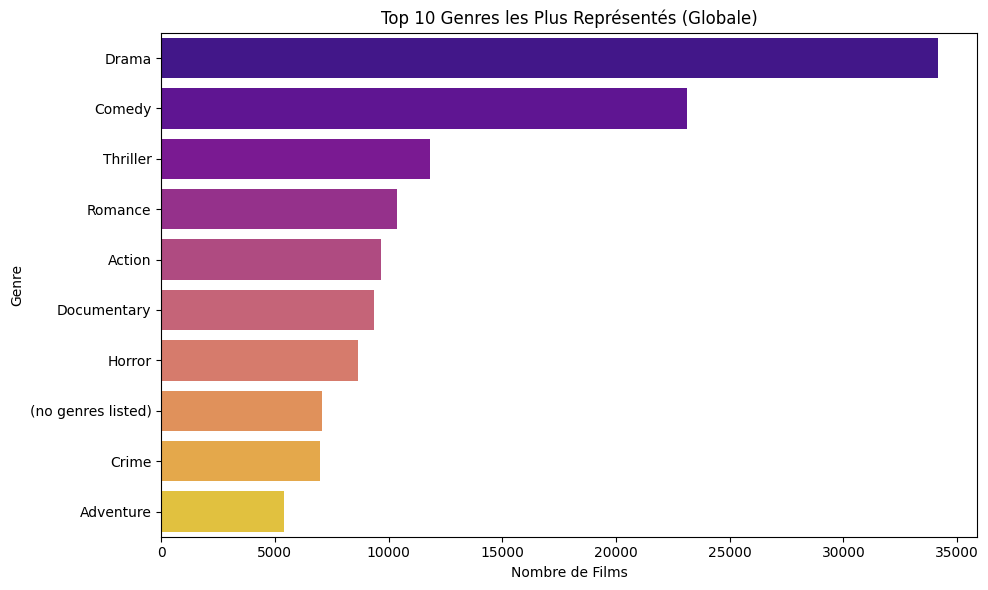

In [7]:
# Genres de films les plus populaires (globale)
print("\nTop 10 genres les plus populaires (globale):")
# explode les genres pour compter chaque genre individuellement
df_movies_genres = df_movies.withColumn("genre", explode(split(col("genres"), "\\|")))
genre_counts_overall = df_movies_genres.groupBy("genre") \
    .agg(count("movieId").alias("num_movies")) \
    .orderBy(col("num_movies").desc()) \
    .limit(10)
genre_counts_overall.show()

# Visualisation des Top 10 genres
plt.figure(figsize=(10, 6))
sns.barplot(
    x="num_movies",
    y="genre",
    data=genre_counts_overall.toPandas(),
    palette="plasma"
)
plt.title("Top 10 Genres les Plus Représentés (Globale)")
plt.xlabel("Nombre de Films")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


Distribution des notes (globale):


C:\Users\arthu\AppData\Local\Temp\ipykernel_29756\3710835118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rating", y="count", data=rating_distribution, palette="coolwarm")


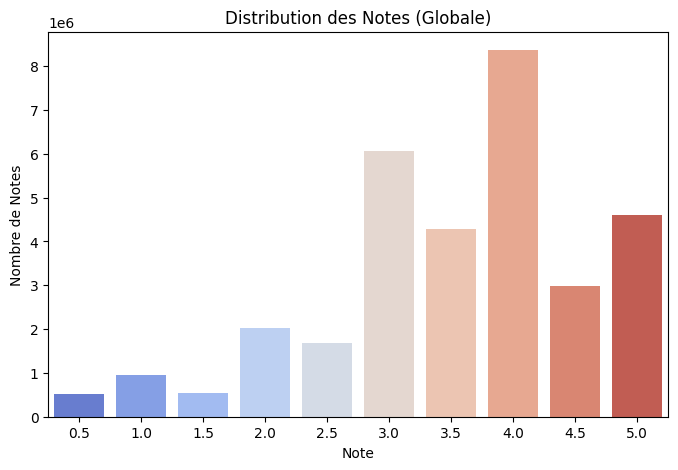

In [8]:
# Distribution des notes
print("\nDistribution des notes (globale):")
rating_distribution = df_ratings.groupBy("rating").agg(count("rating").alias("count")).orderBy("rating").toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x="rating", y="count", data=rating_distribution, palette="coolwarm")
plt.title("Distribution des Notes (Globale)")
plt.xlabel("Note")
plt.ylabel("Nombre de Notes")
plt.show()

In [9]:
print("\n--- Arrêt de la SparkSession pour l'analyse globale ---")
spark.stop()


--- Arrêt de la SparkSession pour l'analyse globale ---


Maintenant qu'à partir de 2018

In [10]:
# --- Section 2: Analyse sur les données depuis 2018 et division Train/Test ---

print("\n--- Redémarrage de la SparkSession pour l'analyse récente et le split Train/Test ---")
spark = SparkSession.builder \
    .appName("RecentDataAnalysisAndSplit") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


--- Redémarrage de la SparkSession pour l'analyse récente et le split Train/Test ---


In [11]:
# Rechargez les datasets nécessaires pour cette session
# Utilisez la version nettoyée de df_movies pour avoir 'release_year'
df_ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
df_movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

# Appliquer le même nettoyage et extraction d'année que précédemment
df_movies = df_movies.withColumn("release_year", regexp_extract(col("title"), "\\((\\d{4})\\)$", 1).cast(IntegerType()))
df_movies = df_movies.na.fill({"release_year": 1900})
df_movies = df_movies.withColumn("title", regexp_replace(col("title"), "\\s\\(\\d{4}\\)$", ""))
df_ratings = df_ratings.na.drop().dropDuplicates(['userId', 'movieId', 'timestamp'])

In [12]:
# Joindre les DataFrames pour l'analyse par année
df_full_recent_analysis = df_ratings.join(df_movies, on="movieId", how="inner")

# Filtrer les données depuis 2018
df_since_2018 = df_full_recent_analysis.filter(col("release_year") >= 2018)

print(f"\nNombre total de notes pour les films depuis 2018 : {df_since_2018.count()}")
print(f"Nombre total de films depuis 2018 : {df_since_2018.select('movieId').distinct().count()}")


Nombre total de notes pour les films depuis 2018 : 772192
Nombre total de films depuis 2018 : 14132


In [13]:
# --- Analyse Exploratoire des Données (EDA) - Données depuis 2018 ---
print("\n--- Analyse Exploratoire des Données (Depuis 2018) ---")

# Top 10 films les mieux notés (depuis 2018, min 500 notes pour la fiabilité)
print("\nTop 10 films les mieux notés (depuis 2018, min 500 notes):")
avg_ratings_since_2018 = df_since_2018.groupBy("title", "genres") \
    .agg(
        count("rating").alias("num_ratings"),
        (spark_sum("rating") / count("rating")).alias("avg_rating")
    ) \
    .filter(col("num_ratings") >= 500) \
    .orderBy(col("avg_rating").desc(), col("num_ratings").desc()) \
    .limit(10)
avg_ratings_since_2018.show(truncate=False)



--- Analyse Exploratoire des Données (Depuis 2018) ---

Top 10 films les mieux notés (depuis 2018, min 500 notes):
+-----------------------------------+-----------------------------------+-----------+------------------+
|title                              |genres                             |num_ratings|avg_rating        |
+-----------------------------------+-----------------------------------+-----------+------------------+
|Parasite                           |Comedy|Drama                       |11670      |4.312253641816624 |
|Spider-Man: Across the Spider-Verse|Action|Adventure|Animation|Sci-Fi  |1133       |4.207413945278023 |
|Spider-Man: Into the Spider-Verse  |Action|Adventure|Animation|Sci-Fi  |10434      |4.1852597278129196|
|Oppenheimer                        |Drama                              |1152       |4.082899305555555 |
|Portrait of a Lady on Fire         |Drama|Romance                      |1586       |4.0561160151324085|
|Everything Everywhere All at Once  |Action|

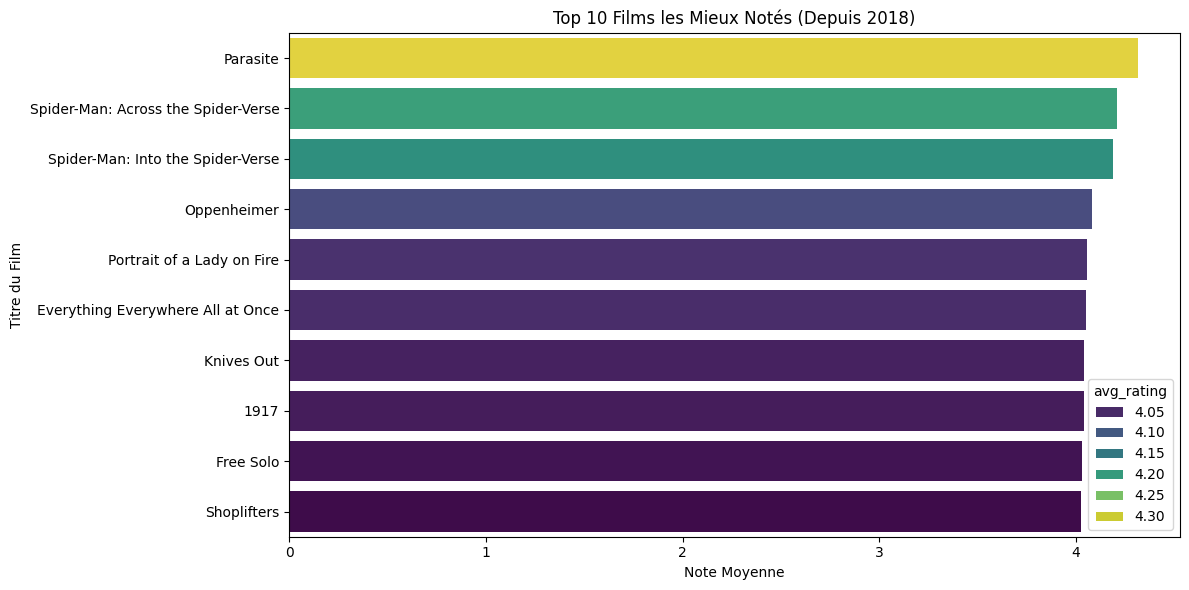

In [14]:
# Visualisation des Top 10 films depuis 2018
plt.figure(figsize=(12, 6))
sns.barplot(
    x="avg_rating",
    y="title",
    hue="avg_rating",
    data=avg_ratings_since_2018.toPandas(),
    palette="viridis",
    dodge=False
)
plt.title("Top 10 Films les Mieux Notés (Depuis 2018)")
plt.xlabel("Note Moyenne")
plt.ylabel("Titre du Film")
plt.tight_layout()
plt.show()

In [15]:
# Top 10 genres les plus populaires (depuis 2018)
print("\nTop 10 des genres les plus populaires (depuis 2018):")
df_movies_genres_since_2018 = df_since_2018.withColumn("genre", explode(split(col("genres"), "\\|")))
genre_counts_since_2018 = df_movies_genres_since_2018.groupBy("genre") \
    .agg(count("movieId").alias("num_movies")) \
    .orderBy(col("num_movies").desc()) \
    .limit(10)
genre_counts_since_2018.show()


Top 10 des genres les plus populaires (depuis 2018):
+---------+----------+
|    genre|num_movies|
+---------+----------+
|    Drama|    307601|
|   Action|    250451|
|   Comedy|    239264|
| Thriller|    194921|
|   Sci-Fi|    184970|
|Adventure|    177474|
|    Crime|    104159|
|   Horror|    100536|
|  Fantasy|     82082|
|Animation|     70259|
+---------+----------+



C:\Users\arthu\AppData\Local\Temp\ipykernel_29756\1185009691.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


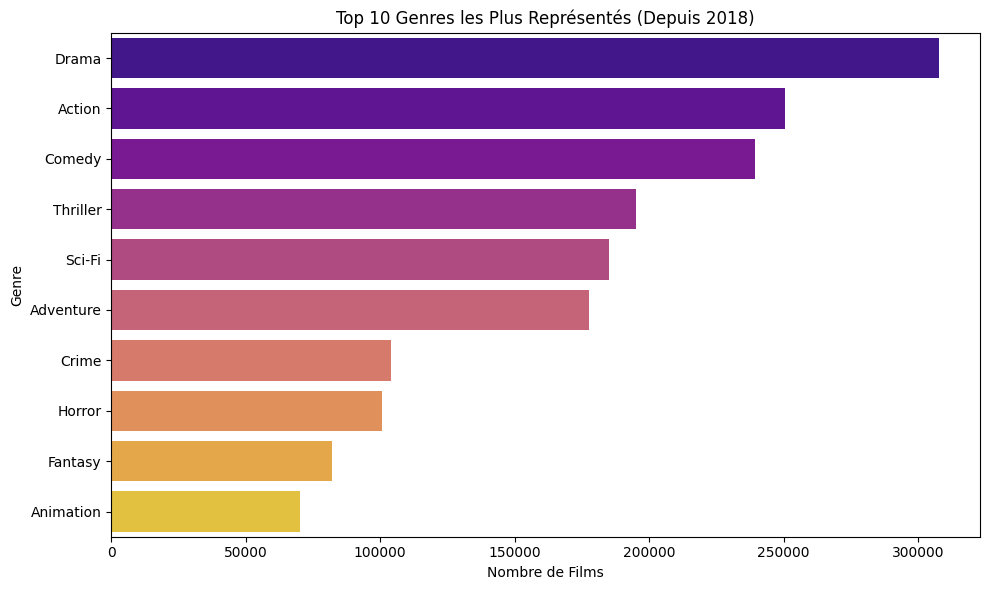

In [16]:
# Visualisation des Top 10 genres depuis 2018
plt.figure(figsize=(10, 6))
sns.barplot(
    x="num_movies",
    y="genre",
    data=genre_counts_since_2018.toPandas(),
    palette="plasma"
)
plt.title("Top 10 Genres les Plus Représentés (Depuis 2018)")
plt.xlabel("Nombre de Films")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [17]:
# --- Division des données pour l'entraînement et le test (Split Temporel) ---

print("\n--- Division des données (Split Temporel) ---")



# Utilisation du DataFrame df_ratings original (nettoyé) pour la division temporelle

# car c'est la base pour l'entraînement des modèles ALS/KNN.

# Trouver le timestamp maximal et minimal pour définir un point de coupe

min_timestamp_all = df_ratings.agg(min("timestamp")).first()[0]

max_timestamp_all = df_ratings.agg(max("timestamp")).first()[0]



# Définir le point de coupe à 80% de l'intervalle de temps

# C'est une approximation, pour un quantile exact, il faudrait une approche plus complexe.

split_timestamp_threshold = min_timestamp_all + (max_timestamp_all - min_timestamp_all) * 0.8



training_data = df_ratings.filter(col("timestamp") <= split_timestamp_threshold)

test_data = df_ratings.filter(col("timestamp") > split_timestamp_threshold)



print(f"Notes d'entraînement (Split Temporel) : {training_data.count()} lignes")

print(f"Notes de test (Split Temporel) : {test_data.count()} lignes")



# --- Sauvegarde des DataFrames préparés ---

print("\n--- Sauvegarde des DataFrames préparés en format Parquet ---")



# Créer le dossier 'data' si n'existe pas

output_dir = "data"

os.makedirs(output_dir, exist_ok=True)



training_data.write.mode("overwrite").parquet(os.path.join(output_dir, "training_data.parquet"))

test_data.write.mode("overwrite").parquet(os.path.join(output_dir, "test_data.parquet"))

df_movies.write.mode("overwrite").parquet(os.path.join(output_dir, "df_movies_cleaned.parquet"))



print(f"Fichiers Parquet sauvegardés dans le dossier : {output_dir}")


--- Division des données (Split Temporel) ---
Notes d'entraînement (Split Temporel) : 24625474 lignes
Notes de test (Split Temporel) : 7374730 lignes

--- Sauvegarde des DataFrames préparés en format Parquet ---


Py4JJavaError: An error occurred while calling o375.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:382)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:354)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:789)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:341)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:331)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:370)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:955)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:192)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:215)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1111)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 23 more


In [ ]:
print("\n--- Arrêt de la SparkSession finale ---")
spark.stop()

print("\n--- Script 01_data_analysis_and_preparation.ipynb Terminé ---")

In [ ]:
print(f"Version de Spark : {spark.version}")

Version de Spark : 3.4.1
